In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from k_means import kmeans
from gmm import gmm
from dbscan import dbscan

# Ejercicio 1: Clustering de datos

In [2]:
archivo_csv = 'clustering.csv'
data = pd.read_csv(archivo_csv)
X = data[['A', 'B']].values


----
### A ) K-Means

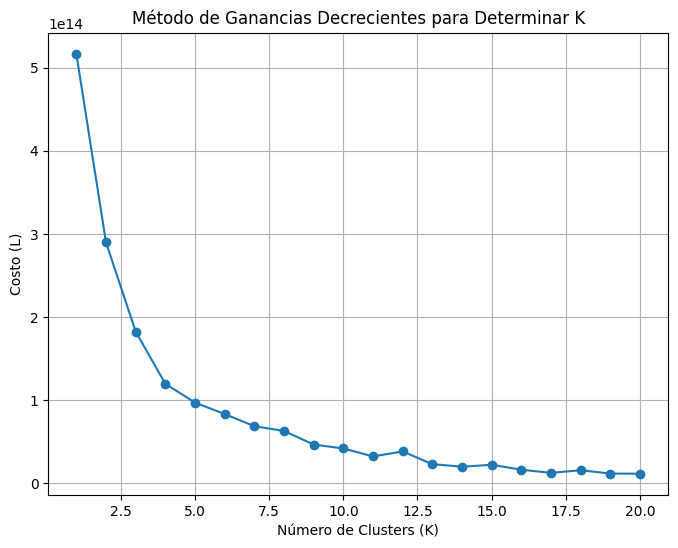

In [5]:
max_K = 20
L_values = []
for K in range(1, max_K + 1):
    r, centroids, L = kmeans(X, K)
    L_values.append(L)

plt.figure(figsize=(8, 6))
plt.plot(range(1, max_K + 1), L_values, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Costo (L)')
plt.title('Método de Ganancias Decrecientes para Determinar K')
plt.grid(True)
plt.show()

#### Tras ver las diferentes pérdidas con los diferentes valores de K y con el métdo de "ganancias descendientes" se decidió que el hiperparámetro óptimo es $K=14$; ya que es el último valor donde K aumenta y L se reduce significamente.

#### Para este valor de K se plotearon cómo quedarían los datos con los clusters y los centroides:

/var/folders/41/r2_v33t512j_hc2xpxfmbjpr0000gn/T/ipykernel_10576/1520751814.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", optimal_K)


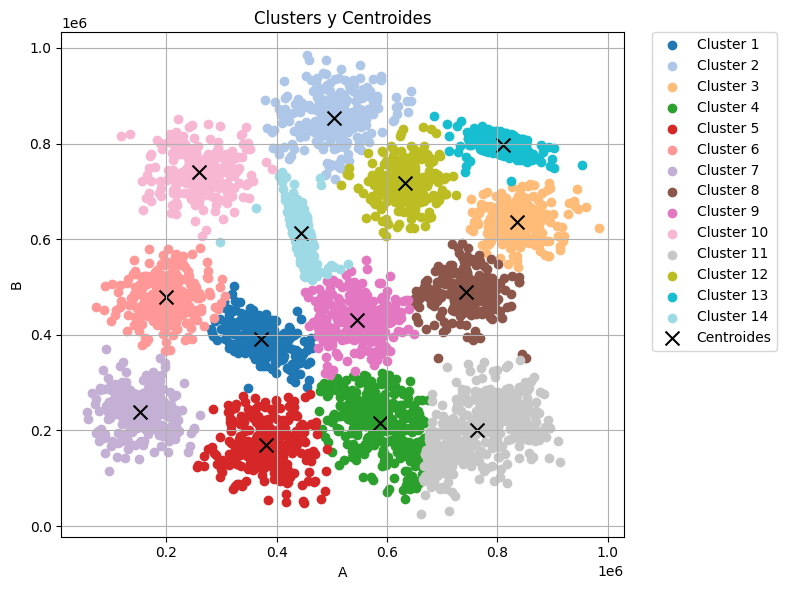

In [49]:
optimal_K = 14 
r, centroids, _ = kmeans(X, optimal_K)

plt.figure(figsize=(8, 6))

cmap = plt.cm.get_cmap("tab20", optimal_K)

for j in range(optimal_K):
    cluster_points = X[r[:, j] == 1]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cmap(j), label=f'Cluster {j+1}')

plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroides')
plt.xlabel('A')
plt.ylabel('B')
plt.title('Clusters y Centroides')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.tight_layout() 
plt.show()

---
### B) Gaussian Mixture Model

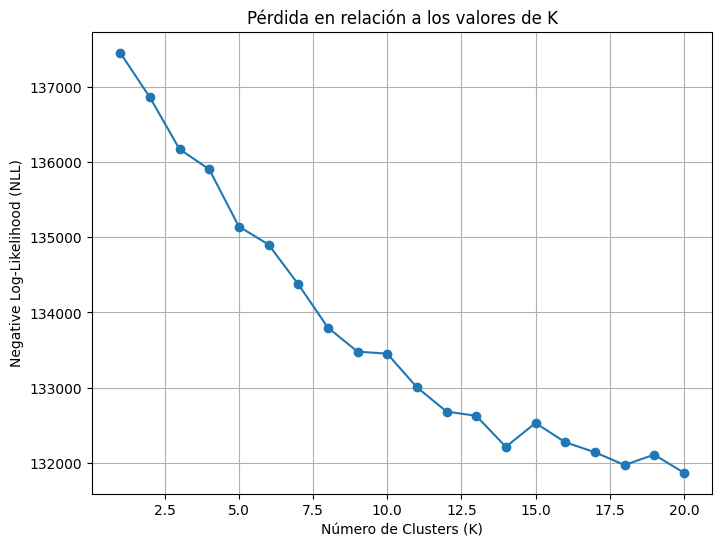

In [88]:

max_K = 20
nll_values = []
for K in range(1, max_K + 1):
    _, _, _, _, nll = gmm(X, K)
    nll_values.append(nll)

plt.figure(figsize=(8, 6))
plt.plot(range(1, max_K + 1), nll_values, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Negative Log-Likelihood (NLL)')
plt.title('Pérdida en relación a los valores de K')
plt.grid(True)
plt.show()

Se escoge de nuevo el $K=14$ para realizar el algoritmo.

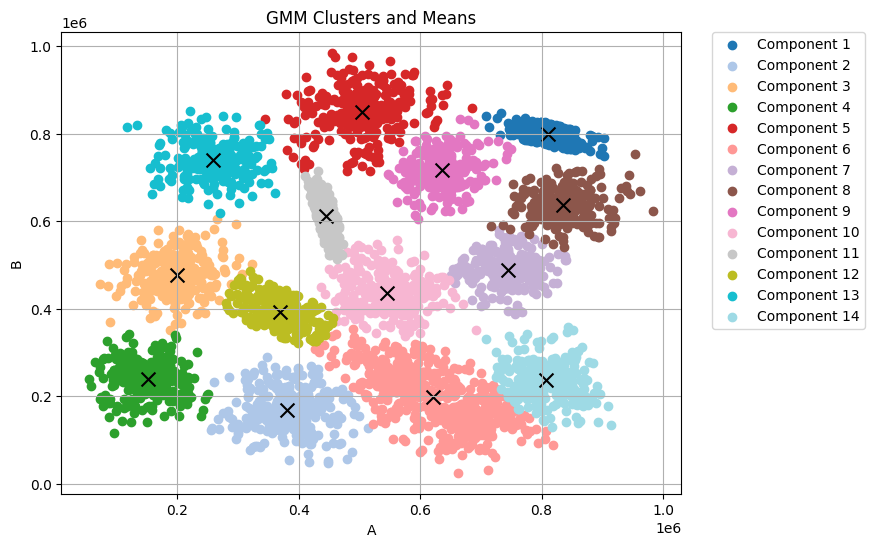

In [81]:
optimal_K = 14
responsibilities, means, covariances, _, _ = gmm(X, optimal_K, max_iters=2000)

plt.figure(figsize=(8, 6))
colors = plt.cm.tab20(np.linspace(0, 1, optimal_K))
for j in range(optimal_K):
    cluster_points = X[np.argmax(responsibilities, axis=1) == j]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[j], label=f'Component {j+1}')
    plt.scatter(means[j, 0], means[j, 1], color='black', marker='x', s=100)  
plt.xlabel('A')
plt.ylabel('B')
plt.title('GMM Clusters and Means')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()

#### Con este método, los cluster más "ovalados" o "estirados" son mejor detectados que en el de K-means, ya que al no ser definido por la distancia euclidiana al centroide, el modelo no clasifica las muestras cercanas por fuera del cluster "ovalado" como si fueran parte de él. Es decir que estos conjuntos de muestras más compactas y un poco irregulares* tienen menos ruido al ser clasificados. 
*Al decir irregular me refiero a no tener una distribución radial.

---
### C ) DBSCAN

Para encontrar los mejores hiperparámetros se intentó realizar el algoritmo combinando 3 valores distintos para $\epsilon$ y par k.

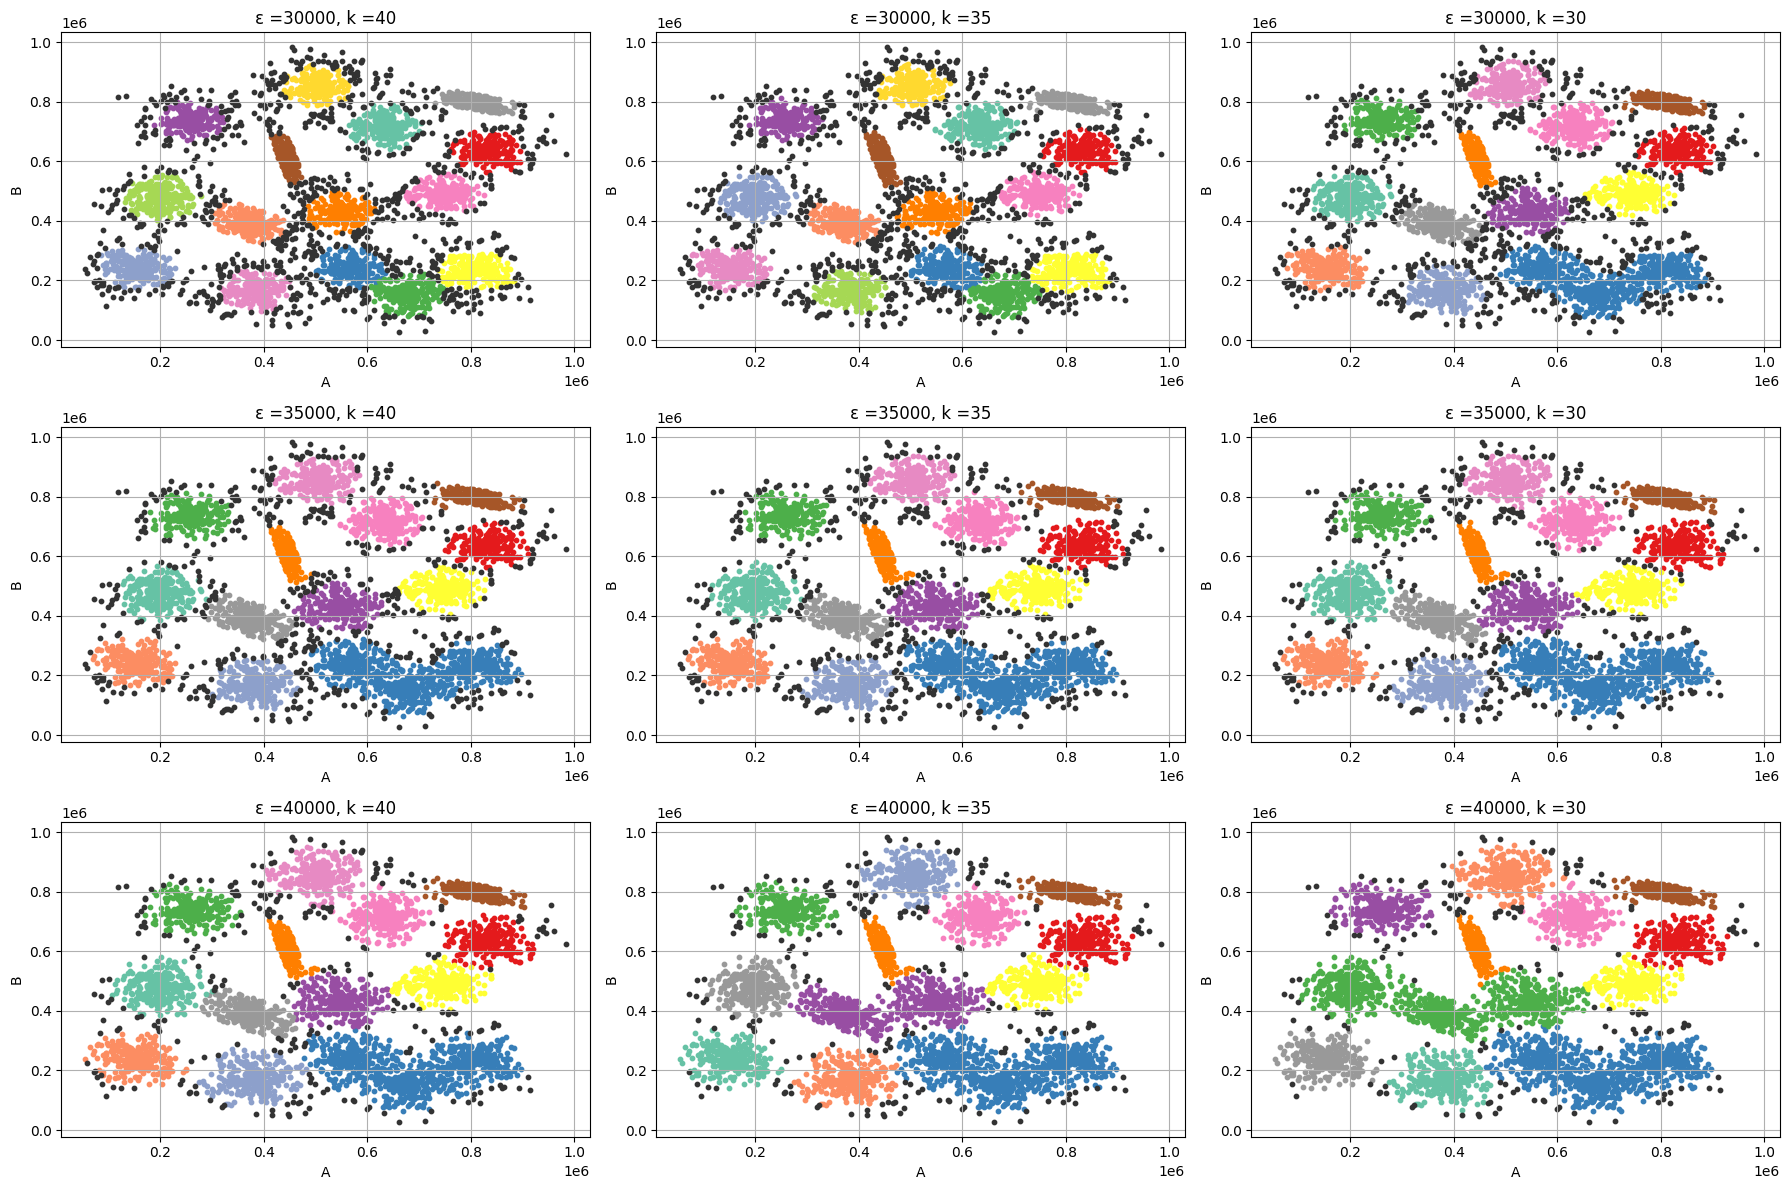

In [31]:
eps_values = [30000, 35000, 40000] 
min_samples_values = [40, 35, 30] 

n_rows = len(eps_values)
n_cols = len(min_samples_values)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12), squeeze=False)

palette = sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("Set3")
for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        labels = dbscan(X, eps=eps, min_samples=min_samples)
        unique_labels = set(labels)
        colors = [palette[label % len(palette)] if label != -1 else (0.2, 0.2, 0.2) for label in unique_labels]
        ax = axes[i, j]
        
        for label, color in zip(unique_labels, colors):
            mask = (labels == label)
            ax.scatter(X[mask, 0], X[mask, 1], c=[color], label=f'Cluster {label}' if label != -1 else 'Noise', s=10)
        
        ax.set_title(f'ε ={eps}, k ={min_samples}')
        ax.set_xlabel('A')
        ax.set_ylabel('B')
        ax.grid(True)

plt.tight_layout()
plt.show()


##### Los modelos con $\epsilon=3000$ y $k=40$ y $k=35$ son los que más clusters logran encontrar, siendo el último el que menos ruido clasifica. Ambos logran clasificar las muestras en 15 diferentes clusters, mientras que con los otros hiperparámetros se logran detectar menos clases, pero clasificanto a menos muestras como ruido. De igual manera, como se trata de aprendizaje no supervisado no hay manera de demostrar que una delimitación o cantidad de clusters es mejor que la otra.

### Aquí está lo mismo pero con los datos de las muestras normalizados. Para los hiperparámetros se utilizaron valores proporcionales a los que se tomaron en el caso anterior. 

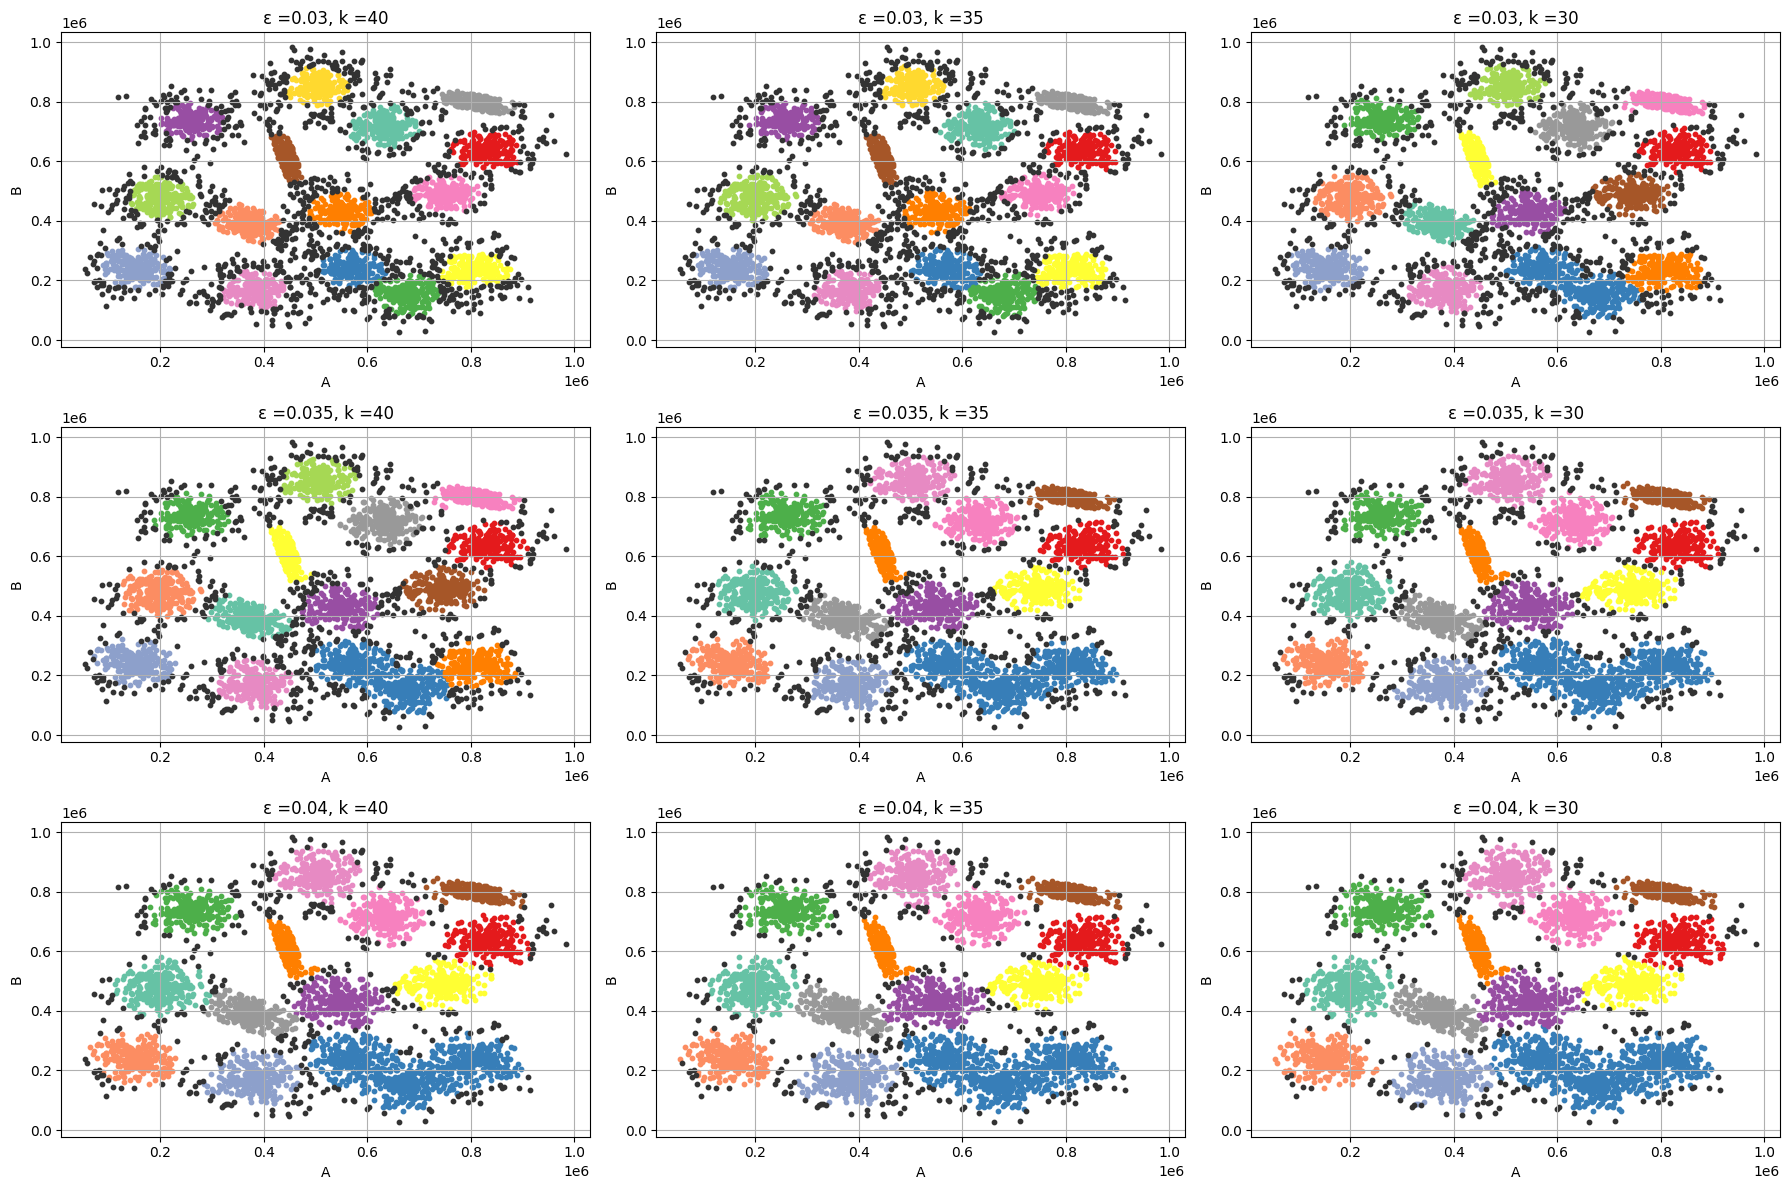

In [5]:
eps_values = [0.03, 0.035, 0.04]
min_samples_values = [40, 35, 30]

X_normalized = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

n_rows = len(eps_values)
n_cols = len(min_samples_values)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12), squeeze=False)

palette = sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("Set3")
for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        labels = dbscan(X_normalized, eps=eps, min_samples=min_samples)
        unique_labels = set(labels)
        colors = [palette[label % len(palette)] if label != -1 else (0.2, 0.2, 0.2) for label in unique_labels]
        ax = axes[i, j]
        
        for label, color in zip(unique_labels, colors):
            mask = (labels == label)
            ax.scatter(X[mask, 0], X[mask, 1], c=[color], label=f'Cluster {label}' if label != -1 else 'Noise', s=10)
        
        ax.set_title(f'ε ={eps}, k ={min_samples}')
        ax.set_xlabel('A')
        ax.set_ylabel('B')
        ax.grid(True)

plt.tight_layout()
plt.show()